<a class="anchor" id="0.1"></a>
# ET data postprocessing

This notebook contains code example to post-process WaPOR ET data, same procedure was followed to postprocess both SEBAL and Landsat provisional ET (SSEBop)
models, steps include:
1. [Calculate ETratio (ET/reference ET)](#ratio)
2. [Gap-filling ETratio](#fill)
3. [Multiply ETratio by ETref](#multiply)
4. [fill raw ET data (cloudy pixels) by `ETref*ETratio`](#fill_et)
5. [Linear interpolation of ETratio to daily timestep](#interpolate)
6. [Multiply daily ETratio by daily ETref](#daily)
7. [Aggregate daily `ETref*ETratio` from step (6) to monthly timestep](#monthly)
8. [Mask monthly ET using the basin's shapefile](#shp)
9. [visualize ET timeseries and export to csv](#vis)



## import necessary libraries

In [2]:
import osr
import os
import gdal
import glob
import pandas as pd
import numpy as np
from datetime import datetime
import watertools.General.raster_conversions as RC
import watertools.General.data_conversions as DC
import matplotlib.pyplot as plt
from watertools.General.raster_conversions import Vector_to_Raster
from watertools.General.data_conversions import  Save_as_tiff

C:\Users\computop\anaconda3\envs\env_sweo_v3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# 1. Calculate ETratio (ET/reference ET) <a class="anchor" id="ratio"></a> 
[ET data postprocessing](#0.1)

In [2]:
def calculate_ET_ratio(eta,etref,output):
    """
    inputs:
    --------
    - eta (str): path to the folder containing evaporation data set
    - etref (str): path to the folder containing reference evapotranspiration data set 
    - output(str): path to the output folder 
    
    """
    rasters_et = sorted(glob.glob(os.path.join(eta, '*.tif')))
    in_fh=rasters_et[0]
    geo_out, proj, size_X, size_Y = RC.Open_array_info(in_fh)
    rasters_etref = sorted(glob.glob(os.path.join(etref, '*.tif')))
    in_fh_list = [os.path.basename(in_fhs)[-12:-8]+"-"+os.path.basename(in_fhs)[-8:-6]+"-"+os.path.basename(in_fhs)[-6:-4] for in_fhs in rasters_et]
    #print(in_fh_list)
    in_fh2_list = [os.path.basename(in_fhs_2)[-14:-4] for in_fhs_2 in rasters_etref]
    common_dates = [dt for dt in in_fh_list if dt in in_fh2_list] #common dates between ETa and ETref
    #print(common_dates)
    for dt in common_dates:
        et=eta+'\et_24_mm_'+dt[0:4]+""+dt[5:7]+""+dt[8:10] +'.tif'
        #print(et)
        eto=etref+'\etref_'+dt+'.tif'
        #print(eto)
        dest_array_et = gdal.Open(et)
        dest_array_etref = RC.reproject_dataset_example(eto, et, 5)
        Array_et = dest_array_et.GetRasterBand(1).ReadAsArray()
        Array_et[Array_et == -9999] = np.nan
        #print(Array_et)
        Array_etref = dest_array_etref.GetRasterBand(1).ReadAsArray()
        Array_etref[Array_etref == -9999] = np.nan
        Array_ratio = Array_et / Array_etref # Etr
        #print(Array_ratio)
        #plt.imshow(Array_ratio); plt.colorbar(); plt.show()
        name="ET_ratio_"+ dt+".tif"
        output_fh= os.path.join(output, name)
        DC.Save_as_tiff(output_fh, Array_ratio, geo_out, proj)


In [3]:
eta=r'D:\WAPOR_runs\Output_Data\ETLook\ETA'
etref=r'D:\WAPOR_runs\Output_Data\ETLook\ETref'
output=r'D:\WAPOR_runs\Output_Data\ETLook\ETratio'
calculate_ET_ratio(eta,etref,output)

# 2. Gap-filling ETratio <a class="anchor" id="fill"></a> 
[ET data postprocessing](#0.1)

In [ ]:

input_folder=r'D:\WAPOR_runs\Output_Data\ETLook\ETratio' #define input_folder
out_folder=r'D:\WAPOR_runs\Output_Data\ETLook\ETratio_gapfilled' # define output folder
images=sorted(glob.glob(input_folder+'\*.tif')) #get list of tif files in the input_folder
template=images[0]
geo_out, proj, size_X, size_Y = RC.Open_array_info(template)



# Loop through the images
for i in range(0, len(images)):
    
    # Open the current image
    image = gdal.Open(images[i])
    
    filename=os.path.basename(images[i])
    year = filename[-14:-10]
    print(year)
    month = filename[-9:-7]
    print(month)
    day = filename[-6:-4]
    print(day)
    date_file= pd.Timestamp((year+'-'+month+'-'+day)).strftime('%Y-%m-%d') #%(year, month, day)
    print(date_file)
    Datum= pd.to_datetime(date_file)
    # Get day of year
    doy = Datum.strftime('%j')
    #print(doy)
    

    # Read the data from the image
    data = image.GetRasterBand(1).ReadAsArray()
    #print(data)
        
    # Use the previous and next images to interpolate missing values
    #prev_image = gdal.Open(images[i - 1])
    prev_image = RC.reproject_dataset_example(images[i-7], images[i], 6) #7 images backward
    prev_array= prev_image.GetRasterBand(1).ReadAsArray()
    
    filename_pre=os.path.basename(images[i - 7])
    year_pre = filename_pre[-14:-10]
    #print(year)
    month_pre= filename_pre[-9:-7]
    #print(month)
    day_pre = filename_pre[-6:-4]
    #print(day)
    date_file_pre= pd.Timestamp((year_pre+'-'+month_pre+'-'+day_pre)).strftime('%Y-%m-%d') #%(year, month, day)
    #print(date_file)
    Datum_pre= pd.to_datetime(date_file_pre)
    # Get day of year
    doy_pre = Datum_pre.strftime('%j')
    #print(doy)
    
    next_image = RC.reproject_dataset_example(images[i + 7], images[i], 6) # 7 images forward
    #next_image = gdal.Open(images[i + 1])
    next_array = next_image.GetRasterBand(1).ReadAsArray()
    
    filename_next=os.path.basename(images[i+ 7])
    year_next = filename_next[-14:-10]
    #print(year)
    month_next= filename_next[-9:-7]
    #print(month)
    day_next = filename_next[-6:-4]
    #print(day)
    date_file_next= pd.Timestamp((year_next+'-'+month_next+'-'+day_next)).strftime('%Y-%m-%d') #%(year, month, day)
    #print(date_file)
    Datum_next= pd.to_datetime(date_file_next)
    # Get day of year
    doy_next = Datum_next.strftime('%j')
    #print(doy)
    
    NewArray= prev_array + (next_array - prev_array)* ((int(doy) - int(doy_pre)) / (int(doy_next) - int(doy_pre)) ) #interpolation
    #NewArray = (prev_array + next_array) / 2 #or simple average
    
    mask = np.isnan(data)
    data[mask] = NewArray[mask]
    #print('new',data)

    output_fh=os.path.join(out_folder,os.path.basename(images[i]))
    DC.Save_as_tiff(output_fh, data, geo_out, proj)




# 3. Multiply ETratio by ETref <a class="anchor" id="multiply"></a> 
[ET data postprocessing](#0.1)

In [6]:
def multiply_ETratio_with_ETref(input_folder, input_folder_2, output_folder):
    """
    Multiply ETratio that has been already filled by ETref
    
    Inputs:
    -------
    - input_folder (str): path to the folder containing ETratio 
    - input_folder_2 (str): path to the folder containing ETref 
    - output_folder (str): path to the output folder 
    """
    images_1 = sorted(glob.glob(os.path.join(input_folder, '*.tif')))
    in_fh_1 = images_1[0]
    geo_out, proj, size_X, size_Y = RC.Open_array_info(in_fh_1)
    in_fh_list = [os.path.basename(in_fhs)[-14:-4] for in_fhs in images_1]
    input_folder_2 = input_folder_2
    rasters = sorted(glob.glob(os.path.join(input_folder_2, '*.tif')))
    in_fh2_list = [os.path.basename(in_fhs_2)[-14:-4] for in_fhs_2 in rasters]

    common_dates = [dt for dt in in_fh_list if dt in in_fh2_list]

    for dt in common_dates:
        in1 = os.path.join(input_folder, f'ET_ratio_{dt}.tif')
        in2 = os.path.join(input_folder_2, f'etref_{dt}.tif')
        dest_array = gdal.Open(in1)
        dest_array2 = RC.reproject_dataset_example(in2, in1, 1)
        Array = dest_array.GetRasterBand(1).ReadAsArray()
        Array2 = dest_array2.GetRasterBand(1).ReadAsArray()
        Array3 = Array * Array2
        name = "ETA_"+ dt+".tif"
        output_fh_1 = os.path.join(output_folder, name)
        DC.Save_as_tiff(output_fh_1, Array3, geo_out, proj)


In [7]:

output_folder=r'D:\WAPOR_runs\Output_Data\ETLook\ETrefxETratio'
input_folder_2=r'D:\WAPOR_runs\Output_Data\ETLook\ETref'
input_folder=r'D:\WAPOR_runs\Output_Data\ETLook\ETratio_gapfilled'

multiply_ETratio_with_ETref(input_folder, input_folder_2, output_folder)

# 4. fill raw ET data (cloudy pixels) by `ETref*ETratio` <a class="anchor" id="fill_et"></a> 
[ET data postprocessing](#0.1)

In [ ]:
output_folder=r'D:\WAPOR_runs\Output_Data\ETLook\ETA_fill'

input_folder=r'D:\WAPOR_runs\Output_Data\ETLook\ETA' #define input_folder
images_1=sorted(glob.glob(input_folder+'\*.tif')) #get list of tif files in the input_folder

in_fh_1=images_1[0]
print(in_fh_1)


geo_out, proj, size_X, size_Y = RC.Open_array_info(in_fh_1)

in_fh_list=[]
for in_fhs in images_1:
    filename_1=os.path.basename(in_fhs)
    in_fh_list.append(filename_1[-12:-4])
#print(filename_1[4:14])
print('et',in_fh_list[0])

input_folder_2=r'D:\WAPOR_runs\Output_Data\ETLook\ETrefxETratio'
rasters=sorted(glob.glob(input_folder_2+'\*.tif'))

in_fh2=rasters[0]
#print(in_fh2)

in_fh2_list=[]
for in_fhs_2 in rasters:
    filename_2=os.path.basename(in_fhs_2)
    #print('filename_2',filename_2)
    in_fh2_list.append(filename_2[-14:-4].replace("-", ""))
#print('etrxeto',in_fh2_list[0])

common_dates=[
    dt for dt in in_fh_list
    if dt in in_fh2_list
]

#print(common_dates)


for dt in common_dates: 
    in1=input_folder+'\et_24_mm_'+dt+'.tif'
    in2=input_folder_2+'\ETA_'+dt[0:4]+"-"+dt[4:6]+"-"+dt[6:8]+'.tif'
    print(in2)
    dest_array = gdal.Open(in1)
    dest_array2 = RC.reproject_dataset_example(in2,in1,5)
    
    Array=dest_array.GetRasterBand(1).ReadAsArray()
    #print((Array.shape))
    Array2=dest_array2.GetRasterBand(1).ReadAsArray()
    #print(Array2.shape)
    
    mask = np.isnan(Array)
    Array[mask] = Array2[mask]

    # Save the filled data to a new image file in the output folder
    name="ETA_"+dt[0:4]+"-"+dt[4:6]+"-"+dt[6:8]+".tif"
    output_fh_1=os.path.join(output_folder,name)
    DC.Save_as_tiff(output_fh_1, Array, geo_out, proj)
    
  

# 5. Linear interpolation of ETratio to daily timestep <a class="anchor" id="interpolate"></a> 
[ET data postprocessing](#0.1)

In [2]:
def linear_interpolation_ET_ratio(input_folder, out_folder):
    """
    Linear interpolation of the ET ratio.

    Inputs:
    -------
    - input_folder (str): path to the folder containing the ET ratio 
    - out_folder (str): path to the output folder 
    """
    images = sorted(glob.glob(os.path.join(input_folder, '*.tif')))
    in_fh = images[0]
    geo_out, proj, size_X, size_Y = RC.Open_array_info(in_fh)

    for i in range(0, len(images) - 1):
        image = gdal.Open(images[i])
        filename = os.path.basename(images[i])
        year = filename[9:13]
        month = filename[14:16]
        day = filename[17:19]
        day2 = int(day) + 1
        date_file = pd.Timestamp((year + '-' + month + '-' + day)).strftime('%Y-%m-%d')
        Datum = pd.to_datetime(date_file)
        doy = Datum.strftime('%j')

        data = image.GetRasterBand(1).ReadAsArray()

        if i + 1 < len(images):
            next_image = RC.reproject_dataset_example(images[i + 1], images[i], 6)
            next_array = next_image.GetRasterBand(1).ReadAsArray()

            filename_next = os.path.basename(images[i + 1])
            year_next = filename_next[9:13]
            month_next = filename_next[14:16]
            day_next = filename_next[17:19]
            date_file_next = pd.Timestamp((year_next + '-' + month_next + '-' + day_next)).strftime('%Y-%m-%d')
            Datum_next = pd.to_datetime(date_file_next)
            doy_next = Datum_next.strftime('%j')

            for x in range(int(doy) + 1, int(doy_next)):
                arr = next_array - data
                arr1 = (x - int(doy))
                arr2 = int(doy_next) - int(doy)
                arr3 = arr1 / arr2
                NewArray = arr * arr3 + data
                name= out_folder+'\ETratio_' + date_file+ "_"+ str(x)+'.tif'
                DC.Save_as_tiff(name, NewArray, geo_out, proj)

In [3]:
etratio_fill=r'D:\WAPOR_runs\Output_Data\ETLook\ETratio_gapfilled'
etratio_interpolate=r'D:\WAPOR_runs\Output_Data\ETLook\ETratio_interpolate'
linear_interpolation_ET_ratio(etratio_fill, etratio_interpolate)

# 6. Multiply daily ETratio by daily ETref <a class="anchor" id="daily"></a> 
[ET data postprocessing](#0.1)

In [14]:
def multiply_ETratio_with_ETref_daily(input_folder, input_folder_2, output_folder):
    """
    Multiply ETratio that has been already filled by ETref
    Inputs:
    -------
    - input_folder (str): path to the folder containing ETratio 
    - input_folder_2 (str): path to the folder containing ETref 
    - output_folder (str): path to the output folder 
    """
    images_1 = sorted(glob.glob(os.path.join(input_folder, '*.tif')))
    in_fh_1 = images_1[0]
    #print(in_fh_1)
    geo_out, proj, size_X, size_Y = RC.Open_array_info(in_fh_1)
    in_fh_list = [os.path.basename(in_fhs)[-14:-4] for in_fhs in images_1]
    rasters = sorted(glob.glob(os.path.join(input_folder_2, '*.tif')))
    in_fh2_list = [os.path.basename(in_fhs_2)[-14:-4] for in_fhs_2 in rasters]

    common_dates = [dt for dt in in_fh_list if dt in in_fh2_list]
    #print('common_dates',common_dates)

    for dt in common_dates:
        in1 = os.path.join(input_folder, f'ETratio_{dt}.tif')
        in2 = os.path.join(input_folder_2, f'etref_{dt}.tif')
        dest_array = gdal.Open(in1)
        dest_array2 = RC.reproject_dataset_example(in2, in1, 1)
        Array = dest_array.GetRasterBand(1).ReadAsArray()
        Array2 = dest_array2.GetRasterBand(1).ReadAsArray()
        Array3 = Array * Array2
        name = "ETA_"+ dt+".tif"
        output_fh_1 = os.path.join(output_folder, name)
        DC.Save_as_tiff(output_fh_1, Array3, geo_out, proj)

In [ ]:
etr_inter=r'D:\WAPOR_runs\Output_Data\ETLook\ETratio_interpolate'
etref_daily=r'D:\WAPOR_runs\Output_Data\ETLook\ETref'
etrefxetr_daily=r"D:\WAPOR_runs\Output_Data\ETLook\ETrefxETr_daily"
multiply_ETratio_with_ETref_daily(etr_inter, etref_daily, etrefxetr_daily)

# 7. Aggregate daily `ETref*ETratio` from step (6) to monthly timestep <a class="anchor" id="monthly"></a> 
[ET data postprocessing](#0.1)

In [16]:
def aggregate_to_monthly(input_folder, out_folder):
    """
    Aggregate daily et to monthly et

    inputs: 
    -------
    
    - input_folder (str): path to the folder containing daily et
    - out_folder (str): path to output folder
    """
    images = sorted(glob.glob(os.path.join(input_folder, '*.tif')))
    in_fh = images[0]
    geo_out, proj, size_X, size_Y = RC.Open_array_info(in_fh)

    ras = []
    for file in os.listdir(input_folder):
        #print(file)
        raster = gdal.Open(input_folder+"/" + file)
        name = os.path.basename(file)
        y = name[4:8]
        m = name[9:11]
        ras.append((raster, y, m))

    groups = {}
    for raster, y, m in ras:
        key = y + "-" + m
        if key not in groups:
            groups[key] = []
        groups[key].append(raster)

    for key, raster_group in groups.items():
        arr_sum = np.zeros((size_Y, size_X))
        count = 0
        for raster in raster_group:
            dest_array = RC.reproject_dataset_example(raster, images[0], 6)
            arr = dest_array.GetRasterBand(1).ReadAsArray()
            arr_sum += arr
            count += 1
        average = arr_sum / count

        file = "\ETA_"+ key+".tif"
        output_fh=out_folder+file
        DC.Save_as_tiff(output_fh, arr_sum, geo_out, proj)


In [17]:
input_ETd=r'D:\WAPOR_runs\Output_Data\ETLook\ETA_daily'
out_ETm=r'D:\WAPOR_runs\Output_Data\ETLook\ETA_monthly'
aggregate_to_monthly(input_ETd, out_ETm)

# 8. Mask monthly ET using the basin's shapefile <a class="anchor" id="shp"></a> 
[ET data postprocessing](#0.1)

In [19]:
def clip_data_shp(input_file,output_folder, shp_filename, IDname = "OBJECTID", number_shp = 0, band = 1):
    """
    Clip the data to the defined extend of the user (latlim, lonlim) or to the
    extend of the DEM tile
    
    --adopted from watertools package

    Keyword Arguments:
    input_file -- output data, output of the clipped dataset
    latlim -- [ymin, ymax]
    lonlim -- [xmin, xmax]
    """
    try:
        if input_file.split('.')[-1] == 'tif':
            dest_in = gdal.Open(input_file)
        else:
            dest_in = input_file
    except:
        dest_in = input_file

    Raster_Basin = Vector_to_Raster(shp_filename, input_file, IDname)
    
    # Create Mask
    MASK = np.where(Raster_Basin == number_shp, 1, np.nan)
    
    # Find IDy
    SumY = np.nansum(MASK, axis = 1)
    IDygood = np.argwhere(SumY>0)
    IDy = [IDygood[0][0], int(IDygood[-1][0]+1)]

    # Find IDX
    SumX = np.nansum(MASK, axis = 0)
    IDxgood = np.argwhere(SumX>0)   
    IDx = [IDxgood[0][0], int(IDxgood[-1][0]+1)]    

    # Get new geotransform
    geo_start = dest_in.GetGeoTransform()
    proj = dest_in.GetProjection()
    
    # Create new geo
    geo_new = tuple([geo_start[0] + geo_start[1] * IDx[0], geo_start[1], 0.0, geo_start[3] + geo_start[5] * IDy[0], 0.0, geo_start[5]])

    # Open Array
    data_in = dest_in.GetRasterBand(band).ReadAsArray()

    # Mask data
    data_temp = data_in * MASK

    # clip data
    data_end = data_temp[IDy[0]:IDy[1],IDx[0]:IDx[1]]
    output_fh=os.path.join(output_folder,os.path.basename(input_file))
    
    Save_as_tiff(output_fh, data_end, geo_new, proj)
    
    #return(data_end, geo_new, proj)

In [26]:
shp_filename=r'D:\WAPOR_runs\Output_Data\ETLook\Shapefile/HindonBasin_HydroBasins.shp'

input_file=out_ETm
output_folder=os.path.join(out_ETm,"Masked")
input_files=sorted(glob.glob(input_file+'\*.tif'))

#print(input_files)
for files in input_files:
    layers=clip_data_shp(files,output_folder, shp_filename)

# 9. visualize ET timeseries and export to csv <a class="anchor" id="vis"></a> 
[ET data postprocessing](#0.1)

D:\WAPOR_runs\Output_Data\ETLook\ETA_monthly\Masked\ETA_2022.01.01.tif


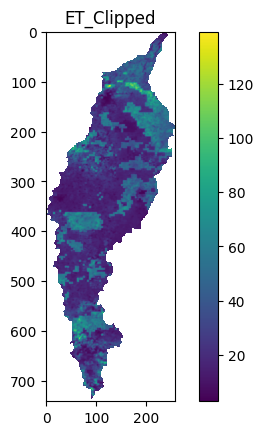

Average ET (mm/month): 30.887739181518555


In [3]:
output_M=r'D:\WAPOR_runs\Output_Data\ETLook\ETA_monthly\Masked'
input_fhs=sorted(glob.glob(output_M+'\*.tif')) #get list of tif files in the input_folder
in_fh=input_fhs[0] #get the path of the first file
print(in_fh)
dest_Array=gdal.Open(in_fh)
Array=dest_Array.GetRasterBand(1).ReadAsArray()
plt.imshow(Array)
plt.colorbar()
plt.title('ET_Clipped')
plt.show()
Average_ET=np.nanmean(Array) #get the mean values
print('Average ET (mm/month): {0}'.format(Average_ET))

In [ ]:
import datetime
dates=[] 
months=[]
years=[]
ET_values=[]
for in_fh in input_fhs:
    filename=os.path.basename(in_fh) # get file name from filehandler string
    #print(filename)
    datestr=filename[-14:-4]#.split('.')[-3].split('_')[2] #get date string from file name
    #print(datestr)
    dyear=int('20'+datestr[2:4]) #get year number from date string
    #print(dyear)
    dmonth=int(datestr[5:7]) #get month number from date string
    #print(dmonth)
    #dates.append(datetime.date(dyear,dmonth,1)) # create datetime object from year and month number
    dates.append(datetime.datetime(dyear, dmonth, 1).date())
    months.append(dmonth) #append to months list
    years.append(dyear) # append to years list
    #Calculate value
    dest_Array=gdal.Open(in_fh)
    ET=dest_Array.GetRasterBand(1).ReadAsArray()
    #ET=OpenAsArray(in_fh,nan_values=True) #open raster as numpy array    
    Average_ET=np.nanmean(ET) # calculate average P
    ET_values.append(Average_ET)    #append to P_values list

C:\Users\computop\anaconda3\envs\env_sweo_v3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


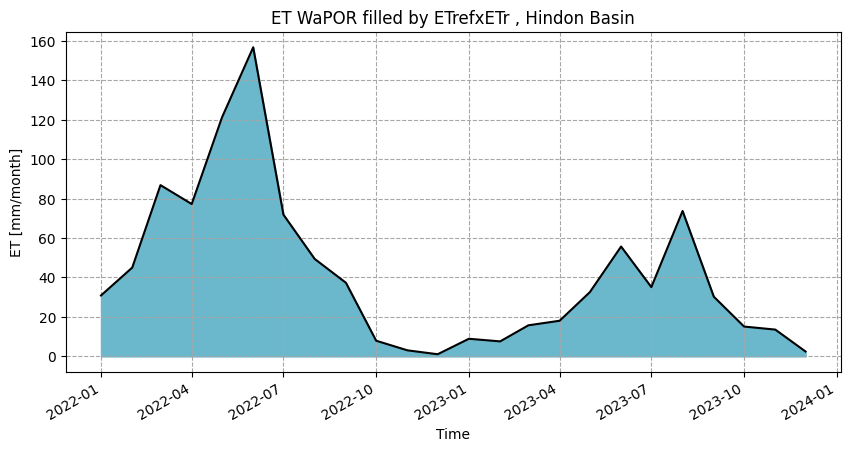

In [25]:
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
plt.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) # Add Grid line
ax = plt.subplot(111)
ax.plot(dates, ET_values, '-k') #Plot data as black line
ax.fill_between(dates, ET_values, color = '#6bb8cc') #Fill line area with blue color
ax.set_xlabel('Time') #Add X axis title
ax.set_ylabel('ET [mm/month]') #Add Y axis title
ax.set_title('ET WaPOR filled by ETrefxETr , Hindon Basin') #Add Figure title
fig.autofmt_xdate() #auto-format dates axis
plt.show()

In [24]:
ET_df=pd.DataFrame({'date':dates,'month':months,'year':years,'ET_fill': ET_values})
ET_df.to_csv(r'ET_WaPOR_monthly_filled.csv',sep=';')
ET_df

,date,month,year,ET_fill
0,2022-01-01,1,2022,30.887739
1,2022-02-01,2,2022,45.025749
2,2022-03-01,3,2022,86.816727
3,2022-04-01,4,2022,77.231651
4,2022-05-01,5,2022,121.113678
5,2022-06-01,6,2022,156.681107
6,2022-07-01,7,2022,71.844597
7,2022-08-01,8,2022,49.403004
8,2022-09-01,9,2022,37.315380
9,2022-10-01,10,2022,7.941315


## Thanks for viewing!